<a href="https://colab.research.google.com/github/KelvinLam05/sms_spam_detection/blob/main/sms_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

In this notebook, we will build a simple, fast, and accurate English-language text classification model with minimal effort. More specifically, we will build a model that classifies text messages as either spam or not.

**Data set information**

The dataset contains one set of text messages in English of 1082 messages, tagged acording being non-spam or spam.


**Load the packages**

In [254]:
# Importing libraries
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text
from sklearn.model_selection import train_test_split

**Load the data**

In [255]:
# Load dataset
df = pd.read_csv('/content/sms_text_messages.csv')

In [256]:
# Change the data frame's column names to lower case
df.columns= df.columns.str.lower()

In [257]:
# Examine the data
df.head()

,message_body,label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will ü b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [258]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   message_body  1082 non-null   object
 1   label         1082 non-null   object
dtypes: object(2)
memory usage: 17.0+ KB


**Check for missing values**

Before moving on, we will check to see if there are any null values to impute. However, the data were all fine, so there was nothing to do.

In [259]:
df.isnull().sum().sort_values(ascending = False)

message_body    0
label           0
dtype: int64

**Examine the data**

By running value_counts( ) on the label column containing our target variable, we can see that the data are imbalanced.

In [260]:
df['label'].value_counts(normalize = True) * 100

Non-Spam    81.700555
Spam        18.299445
Name: label, dtype: float64

**SMS message length**

Let's make a new column to detect how long the text messages are:

In [261]:
df['message_length'] = df['message_body'].apply(lambda x: len(x))

In [262]:
df['message_length'].describe()

count    1082.000000
mean       82.894640
std        56.432321
min         2.000000
25%        37.000000
50%        66.500000
75%       132.000000
max       446.000000
Name: message_length, dtype: float64

The maximum length of a text message is 446 characters. 

The character limit for a single SMS message is technically 160 characters. However, most modern phones and networks support message concatenation: they split large messages into individual SMS messages (called "segments") and then re-create the large message at the receiving end. 

**Split the train and test data**

In [263]:
X = df.drop(['label'], axis = 1)

In [264]:
y = df['label']

In [265]:
# Stratified sampling based on the distribution of the target vector, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

**Encode target labels**

In [266]:
from sklearn.preprocessing import LabelEncoder

In [267]:
le = LabelEncoder()

In [268]:
y_train_enc = y_train.copy()

In [269]:
y_train_enc = pd.DataFrame(data = y_train_enc, columns = ['label'])

In [270]:
y_train_enc['label_encoded'] = le.fit_transform(y_train_enc['label'].values)

In [271]:
y_train_enc

,label,label_encoded
95,Non-Spam,0
1052,Non-Spam,0
542,Non-Spam,0
550,Non-Spam,0
808,Spam,1
...,...,...
358,Non-Spam,0
456,Spam,1
630,Non-Spam,0
293,Non-Spam,0


In [272]:
# Label encode the target variable 
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

**Preprocess data and build a transformer model**

With the Transformer API in ktrain, we can select any Hugging Face transformers model appropriate for our data. Since we are dealing with SMS spam, we will use smaller BERT by the author mrm8488.


In [273]:
# Transformer model
MODEL_NAME = 'mrm8488/bert-tiny-finetuned-sms-spam-detection' 

We must supply a class_names argument to the Transformer constructor, which tells ktrain how indices map to class names. In this case, class_names = ['Non-spam', 'Spam'] because 0 = Non-spam, 1 = Spam.

In [274]:
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = ['Non-Spam', 'Spam'])

In [275]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['message_body'])
X_tr = X_tr['message_body'].tolist()

In [276]:
y_tr = pd.DataFrame(data = y_train, columns = ['label'])
y_tr = y_tr['label'].tolist()

In [277]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['message_body'])
X_te = X_te['message_body'].tolist()

In [278]:
y_te = pd.DataFrame(data = y_test, columns = ['label'])
y_te = y_te['label'].tolist()

In [279]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 32
	99percentile : 50


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 33
	99percentile : 47


In [ ]:
# Model classifier
model = t.get_classifier()

In [281]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

To train the model, we will first find the optimal learning rate that suits well to our problem. ktrain provides a very good method named lr_find which trains the model at different learning rates and plots loss of the model as the learning rate is increased.

In [282]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 3) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
144/144 [==============================] - 10s 33ms/step - loss: 0.1224 - accuracy: 0.9780
Epoch 2/3
144/144 [==============================] - 5s 34ms/step - loss: 0.2110 - accuracy: 0.9313
Epoch 3/3
144/144 [==============================] - 1s 4ms/step - loss: 1.7857 - accuracy: 0.7273


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


The learning rate plot can be observed by calling the following method:

Three possible suggestions for LR from plot:
	Longest valley (red): 1.82E-04
	Min numerical gradient (purple): 1.35E-05
	Min loss divided by 10 (omitted from plot): 6.81E-05


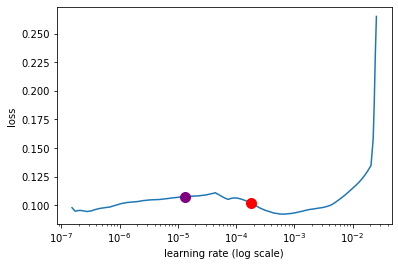

In [283]:
# Visually identify best learning rate
learner.lr_plot(suggest = True)

We will now train the model using the autofit method. The method trains the classifier and automatically selects the best performing one preventing underfitting and overfitting of the model.

In [284]:
# Training using the autofit policy
learner.autofit(1.82E-04, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.000182...
Epoch 1/1024
145/145 [==============================] - 8s 28ms/step - loss: 0.0955 - accuracy: 0.9780 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 2/1024
145/145 [==============================] - 4s 24ms/step - loss: 0.0599 - accuracy: 0.9827 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 3/1024
145/145 [==============================] - 3s 23ms/step - loss: 0.0363 - accuracy: 0.9908 - val_loss: 0.0287 - val_accuracy: 0.9862
Epoch 4/1024
145/145 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9942
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 9.1e-05 (if not early_stopping).
145/145 [==============================] - 3s 23ms/step - loss: 0.0242 - accuracy: 0.9942 - val_loss: 0.0227 - val_accuracy: 0.9908
Epoch 5/1024
145/145 [==============================] - 4s 24ms/step - loss: 0.0116 - accuracy: 0.9988 - v

**Evaluate/Inspect model**

In [285]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

    Non-Spam       1.00      1.00      1.00       177
        Spam       1.00      1.00      1.00        40

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



array([[177,   0],
       [  0,  40]])

Our spam filter with 1.00 precision and 1.00 recall has an F1 score of 1.00. 